In [12]:
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
import torch
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import torch
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset

In [13]:
# Image transforms
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [16]:
# Path to dataset
data_dir = 'C:/Users/Омар/FinalAnalysis/TrashNet/.venv/data/dataset-resized'
batch_size = 32
num_classes = 6
seed = 42

In [17]:
# Load entire dataset temporarily (with dummy transform)
full_dataset = datasets.ImageFolder(root=data_dir, transform=transforms.ToTensor())

In [18]:
# Split dataset into train/val/test
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

In [19]:
torch.manual_seed(seed)
train_idx, valid_idx, test_idx = random_split(full_dataset, [train_size, valid_size, test_size])

In [20]:
# Reassign transforms per subset
train_set = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['train']), train_idx.indices)
valid_set = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['valid']), valid_idx.indices)
test_set  = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['test']),  test_idx.indices)

In [21]:
# Create dataloaders
train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_data = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_data  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [22]:
print(f"Train: {len(train_set)}, Valid: {len(valid_set)}, Test: {len(test_set)}")
print(f"Classes: {full_dataset.classes}")

Train: 1768, Valid: 252, Test: 507
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [23]:
# Load model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
loss_criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# Training loop with tqdm
epochs = 20

for epoch in range(epochs):
    start_time = time.time()
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    train_loss, train_acc = 0.0, 0.0
    loop = tqdm(train_data, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        train_acc += torch.sum(preds == labels).item()

        loop.set_postfix(loss=loss.item())

C:\Users\Омар\FinalAnalysis\TrashNet\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Омар\FinalAnalysis\TrashNet\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Омар/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:07<00:00, 14.3MB/s]



Epoch 1/20



Epoch 2/20



Epoch 3/20



Epoch 4/20



Epoch 5/20



Epoch 6/20



Epoch 7/20



Epoch 8/20



Epoch 9/20



Epoch 10/20



Epoch 11/20



Epoch 12/20



Epoch 13/20



Epoch 14/20



Epoch 15/20



Epoch 16/20



Epoch 17/20



Epoch 18/20



Epoch 19/20



Epoch 20/20


In [25]:
# Validation phase
model.eval()
val_loss, val_acc = 0.0, 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    loop = tqdm(valid_data, desc="Validating", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)

        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        val_acc += torch.sum(preds == labels).item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(loss=loss.item())

# Average loss and accuracy
val_loss /= len(valid_data.dataset)
val_acc /= len(valid_data.dataset)

# Classification report
print("\nValidation Metrics:")
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Confusion Matrix (optional, for display/debugging)
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)


Validation Metrics:
Val Loss: 0.5316, Val Accuracy: 0.8532

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.82      0.92      0.87        36
       glass       0.87      0.85      0.86        40
       metal       0.80      0.91      0.85        43
       paper       0.88      0.91      0.90        58
     plastic       0.88      0.87      0.87        60
       trash       0.80      0.27      0.40        15

    accuracy                           0.85       252
   macro avg       0.84      0.79      0.79       252
weighted avg       0.85      0.85      0.84       252

Confusion Matrix:
[[33  0  1  2  0  0]
 [ 0 34  4  0  2  0]
 [ 0  2 39  1  0  1]
 [ 3  0  0 53  2  0]
 [ 1  3  2  2 52  0]
 [ 3  0  3  2  3  4]]


In [28]:
# Ensure ASCII-safe and permission-safe path
model_dir = '../.venv/model_output'
os.makedirs(model_dir, exist_ok=True)
filepath = os.path.join(model_dir, 'trashnet.pt')

In [29]:
# Save model
torch.save(model.state_dict(), filepath)
print(f"Model saved to {filepath}")

Model saved to model_output\trashnet.pt


In [32]:
# Define class names based on folder order in your dataset
class_names = [
    'cardboard',
    'glass',
    'metal',
    'paper',
    'plastic',
    'trash'
]

In [33]:
# Image transform (must match validation/test transform used in training)
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [42]:
def predict(model, image_path):
    image = Image.open(image_path).convert("RGB")
    transformed = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed)
        _, predicted = torch.max(output, 1)
    return predicted.item(), image

In [43]:
def make_prediction(model_path, image_path):
    model = models.resnet50(pretrained=False)
    fc_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(fc_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 6),
        nn.LogSoftmax(dim=1)
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    predicted_idx, original_image = predict(model, image_path)
    predicted_label = class_names[predicted_idx]

    # Show image with prediction
    plt.imshow(original_image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

In [44]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

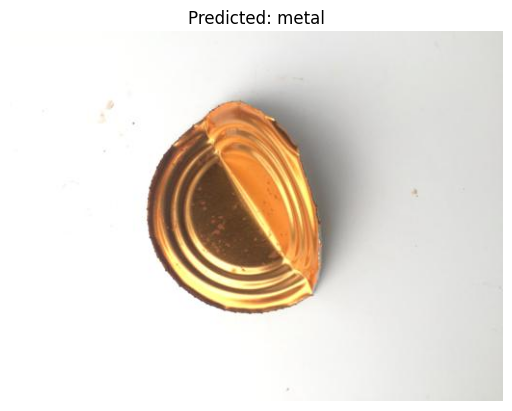

Predicted class: metal


In [45]:
# Entry point
if __name__ == '__main__':
    model_path = '/src/model_output/trashnet.pt'  # Adjust as needed
    image_path = 'C:/Users/Омар/FinalAnalysis/TrashNet/.venv/data/dataset-resized/metal/metal2.jpg'  # Replace with your test image path

    result = make_prediction(model_path, image_path)
    print("Predicted class:", result)